Libraries used in this project

In [3]:
import pandas as pd
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D,Bidirectional
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import keras_metrics
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
#STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
import plotly.graph_objs as go
import chart_studio.plotly as py
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
!pip install keras_metrics

Loading the dataset


In [4]:
#olidData=pd.read_csv('olid-training-v1.0.tsv', sep='\t')
olidData=pd.read_csv('training_data.tsv', sep='\t')
#olidData['mergedSubTasks'] = olidData[['subtask_a', 'subtask_b', 'subtask_c']].apply(lambda x: ', '.join(x[x.notnull()]), axis = 1)
olidData

,id,text,actual_label
0,1186892495466057729,Idc what anyone says I will never pay $7 for a...,NOT
1,1187874856047542272,@USER Turn it off. It's way more trouble then ...,NOT
2,1158012106672869376,You are the most beautiful young lady being I'...,NOT
3,1158240390371299329,cat #2 is finally done pouting after i cut her...,NOT
4,1162167449573154821,Hello crush Please don't be inlove with someon...,NOT
...,...,...,...
991257,1188008936437436417,@USER Yep we are one of two main benefactors ...,NOT
991258,1156380291499515904,@USER How the fuck does stuff like that happen??,"OFF, TIN, IND"
991259,1187809616664633347,@USER @USER Sick bastard. Making fun of killin...,"OFF, TIN, IND"
991260,1160340145406537731,"@USER His story just same with me then :""",NOT


In [0]:
testData=pd.read_csv('olid-training-v1.0.tsv', sep='\t')
testData['actual_label'] = olidData[['subtask_a', 'subtask_b', 'subtask_c']].apply(lambda x: ', '.join(x[x.notnull()]), axis = 1)
testData

Cleaning dataset


In [5]:
nlp = spacy.load("en_core_web_sm")
olidData = olidData.reset_index(drop=True)
re_space = re.compile('[/(){}\[\]\|@,;]')
re_symbols = re.compile('[^0-9a-z #+_]')
stop_words = set(stopwords.words('english'))
re_user=re.compile('(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9-_]+)')

def clean_text(text):
    text=re_user.sub('Person', text)
    lower = text.lower()
    space_replace = re_space.sub(" ",lower)
    nosymb = re_symbols.sub("",space_replace)
    text = re.sub(r"\s*\b(?:{})\b".format("|".join(stop_words)), "", nosymb)
    doc = nlp(text)
    for entity in doc.ents:
      if entity.label_=="PERSON" or entity.label_=="NORP" or entity.label_=="ORG" or entity.label_=="GPE":
          text=text.replace(entity.text, entity.label_)
    return re.sub(r" {2,}", " ", text.strip())

olidData['text'] = olidData['text'].apply(clean_text)
olidData
#a=clean_text(olidData.iloc[13238].tweet)
#a

KeyboardInterrupt: ignored

In [0]:
maxWords = 50000
maxLength = 250
embedDimension = 100

tokenizer = Tokenizer(num_words=maxWords, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(olidData['text'])
indexedWords = tokenizer.word_index
print('Found %s unique tokens.' % len(indexedWords))

#X = tokenizer.texts_to_sequences(olidData['text'].values)
#X = pad_sequences(X, maxlen=maxLength)

X_train = tokenizer.texts_to_sequences(olidData['text'].values)
X_train = pad_sequences(X_train, maxlen=maxLength)
print('Shape of data tensor:', X_train.shape)

#Y = pd.get_dummies(olidData['mergedSubTasks'])
Y_train = pd.get_dummies(olidData['actual_label'])
print('Shape of label tensor:', Y_train.shape)

#train_pct_index = int(0.8 * len(X))
#X_train, X_test = X[:train_pct_index], X[train_pct_index:]
#Y_train, Y_test = Y[:train_pct_index], Y[train_pct_index:]

#X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
#print(X_test.shape,Y_test.shape)

Found 20373 unique tokens.
Shape of data tensor: (13240, 250)
Shape of label tensor: (13240, 5)
(10592, 250) (10592, 5)
(2648, 250) (2648, 5)


LSTM model


In [0]:
lstmModel = Sequential()
lstmModel.add(Embedding(maxWords, embedDimension, input_length=X.shape[1]))
lstmModel.add(SpatialDropout1D(0.2))
#biDirModel.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
lstmModel.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
lstmModel.add(Dense(5, activation='softmax'))
lstmModel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(lstmModel.summary())

# LSTM model training
epochs = 10
batch_size = 128

history = lstmModel.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 505       
Total params: 5,080,905
Trainable params: 5,080,905
Non-trainable params: 0
_________________________________________________________________
None
Train on 9532 samples, validate on 1060 samples
Epoch 1/10
9532/9532 [==============================] - 66s 7ms/step - loss: 1.0877 - acc: 0.6616 - val_loss: 1.0538 - val_acc: 0.6500
Epoch 2/10
9532/9532 [==============================] 

Testing of LSTM model

In [0]:
accr = lstmModel.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

2648/2648 [==============================] - 6s 2ms/step
Test set
  Loss: 1.102
  Accuracy: 0.676


BiLSTM Model

In [0]:
biDirModel = Sequential()
biDirModel.add(Embedding(maxWords, embedDimension, input_length=X.shape[1]))
biDirModel.add(SpatialDropout1D(0.2))
biDirModel.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
#lstmModel.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
biDirModel.add(Dense(5, activation='softmax'))
biDirModel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(biDirModel.summary())

# BiLSTM model training
epochs = 10
batch_size = 128

history = biDirModel.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 250, 100)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               160800    
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 1005      
Total params: 5,161,805
Trainable params: 5,161,805
Non-trainable params: 0
_________________________________________________________________
None
Train on 9532 samples, validate on 1060 samples
Epoch 1/10
9532/9532 [==============================] - 123s 13ms/step - loss: 1.0726 - acc: 0.6591 - val_loss: 1.0415 - val_acc: 0.6500
Epoch 2/10
9532/9532 [==============================

Testing BiLSTM model

In [0]:
accr = biDirModel.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

2648/2648 [==============================] - 10s 4ms/step
Test set
  Loss: 1.123
  Accuracy: 0.687


Nueral network without any lstm or bilstm layer

In [0]:
neuralNetworkModel = Sequential()
neuralNetworkModel.add(Dense(500, activation='relu', input_dim=250))
# model.add(Dense(100, activation='relu'))
# model.add(Dense(50, activation='relu'))
neuralNetworkModel.add(Dense(5, activation='softmax'))

# Compile the model
neuralNetworkModel.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
print(neuralNetworkModel.summary())
history=neuralNetworkModel.fit(X_train, Y_train, epochs=epochs)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 500)               125500    
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 2505      
Total params: 128,005
Trainable params: 128,005
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
10592/10592 [==============================] - 3s 240us/step - loss: 5.5140 - acc: 0.6567
Epoch 2/10
10592/10592 [==============================] - 1s 135us/step - loss: 5.3573 - acc: 0.6668
Epoch 3/10
10592/10592 [==============================] - 1s 129us/step - loss: 5.3516 - acc: 0.6671
Epoch 4/10
10592/10592 [==============================] - 1s 130us/step - loss: 5.3530 - acc: 0.6672
Epoch 5/10
10592/10592 [==============================] - 1s 132us/step - loss: 5.3780 - acc: 0.6653


Testing neural network

In [0]:
accr = neuralNetworkModel.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

2648/2648 [==============================] - 1s 198us/step
Test set
  Loss: 5.327
  Accuracy: 0.669


Create dataframe using InsertPredictions function with the test data and predict.

In [0]:
import numpy as np

def InsertPredictions(test_data,model):
    lstNot=[]
    lstOffGrp=[]
    lstOffInd=[]
    lstOffOth=[]
    lstOffUnt=[]
    lst=["NOT","OFF, TIN, GRP","OFF, TIN, IND","OFF, TIN, OTH","OFF, UNT"]
    dd=olidData[train_pct_index:]
    lst_text = dd['tweet'].tolist()
    y_prob = model.predict(test_data)
    for prob in y_prob:
      lstNot.append(prob[0])
      lstOffGrp.append(prob[1])
      lstOffInd.append(prob[2])
      lstOffOth.append(prob[3])
      lstOffUnt.append(prob[4])
    y_classes = y_prob.argmax(axis=-1)
    lst_classes=y_classes.tolist()
    lst_predictions = [lst[i] for i in lst_classes]
    lst_original=dd['mergedSubTasks'].tolist()
    lst_prob=y_prob.tolist()
    df = pd.DataFrame(lst_text,columns =['tweet'])
    df['Original']=lst_original
    df['Predictions']=lst_predictions
    df['Not Off.']=lstNot
    df['Off. Group']=lstOffGrp
    df['Off. Ind.']=lstOffInd
    df['Off. Others']=lstOffOth
    df['Off. Untargeted']=lstOffUnt
    lstSummary=[]
    for index, row in df.iterrows():
      if row['Original']==row['Predictions']:
        lstSummary.append(1)
      else:
        lstSummary.append(0)
    df['IsCorrect']=lstSummary
    return df

predicted=InsertPredictions(X_test,biDirModel)
predicted

#y_classes = keras.np_utils.probas_to_classes(y_proba)
#y_classes[0][0]

,tweet,Original,Predictions,Not Off.,Off. Group,Off. Ind.,Off. Others,Off. Untargeted,IsCorrect
0,person nancy lee grahn awesome fan since santa...,NOT,NOT,0.998486,0.000328,0.000828,0.000194,0.000164,1
1,person skrull enemy kree kree gave carol power...,NOT,"OFF, TIN, IND",0.303999,0.183110,0.373911,0.071589,0.067391,0
2,person person person person person person pers...,NOT,NOT,0.976066,0.006468,0.005784,0.008271,0.003411,1
3,person person person beautiful,NOT,NOT,0.996849,0.000804,0.001168,0.000665,0.000515,1
4,person happens liberals get control,NOT,NOT,0.902620,0.061402,0.007425,0.022665,0.005889,1
...,...,...,...,...,...,...,...,...,...
2643,person sometimes get strong vibes people mans ...,"OFF, TIN, IND","OFF, TIN, IND",0.263370,0.037808,0.631851,0.017672,0.049299,1
2644,benidorm creamfields maga shabby summer,NOT,NOT,0.906203,0.018896,0.052652,0.010887,0.011362,1
2645,person report garbage dont give crap,"OFF, TIN, OTH","OFF, TIN, IND",0.017757,0.143345,0.535171,0.109402,0.194324,0
2646,person pussy,"OFF, UNT","OFF, TIN, IND",0.103478,0.060730,0.612048,0.063026,0.160719,0


In [0]:
def calScores(frame):
  lst=['NOT','OFF, TIN, GRP','OFF, TIN, IND','OFF, TIN, OTH','OFF, UNT']
  lstFscore=[]
  for item in lst:
    tp=len(frame[(frame['IsCorrect']==1) & (frame['Predictions']==item)])
    fp=len(frame[(frame['IsCorrect']==0) & (frame['Predictions']==item)])
    #precision=tp/tp+fp
    precision=tp/(tp+fp)
    print("Precision for "+item+" : "+str(precision))
    fn=len(frame[(frame['Original']==item) & (frame['Predictions']!=item)])
    recall=tp/(tp+fn)
    print("Recall for "+item+" : "+str(recall))
    fScore=(2*precision*recall)/(precision+recall)
    lstFscore.append(fScore)
  return lstFscore

tp=len(predicted[(predicted['IsCorrect']==1) & (predicted['Predictions']=='OFF, UNT')])
fp=len(predicted[(predicted['IsCorrect']==0) & (predicted['Predictions']=='OFF, UNT')])
print(tp,fp)
calScores(predicted)

0 5
Precision for NOT : 0.7792860734037205
Recall for NOT : 0.8752117447769622
Precision for OFF, TIN, GRP : 0.3419354838709677
Recall for OFF, TIN, GRP : 0.2409090909090909
Precision for OFF, TIN, IND : 0.4585858585858586
Recall for OFF, TIN, IND : 0.47489539748953974
Precision for OFF, TIN, OTH : 0.0
Recall for OFF, TIN, OTH : 0.0


ZeroDivisionError: ignored

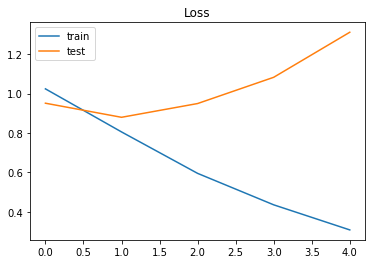

In [0]:

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

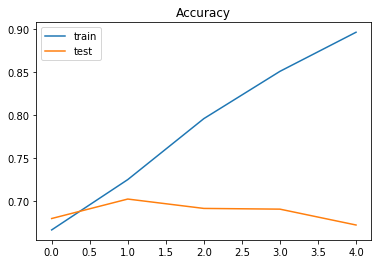

In [0]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

In [0]:
olidData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13240 entries, 0 to 13239
Data columns (total 6 columns):
id                13240 non-null int64
tweet             13240 non-null object
subtask_a         13240 non-null object
subtask_b         4400 non-null object
subtask_c         3876 non-null object
mergedSubTasks    13240 non-null object
dtypes: int64(1), object(5)
memory usage: 620.8+ KB


In [0]:
apiData=pd.read_csv('apiData.csv', sep='\t')
apiData

,Unnamed: 0,id,id_str,text,user_id,user_screen_name,created_at
0,0,1205982163549728769,1205982163549728769,RT @BruthaManTho: #ArmyNavyGame nothing like s...,772787304,ArriolaAnn,Sat Dec 14 22:45:28 +0000 2019
1,1,1205982164061446146,1205982164061446146,RT @bbcstrictly: The #Strictly class of 2019 a...,91434042,em_katexo,Sat Dec 14 22:45:28 +0000 2019
2,2,1205982164094988288,1205982164094988288,@MissFrance Miss Provence !,1088924476975263746,CharlotteTaquet,Sat Dec 14 22:45:28 +0000 2019
3,3,1205982164153782273,1205982164153782273,#StrictlyFinal I know the standard is good in ...,917385627649429504,Julie_Dawson12,Sat Dec 14 22:45:28 +0000 2019
4,4,1205982164988256256,1205982164988256256,RT @Michy043: ARMY please read this is really ...,1147779470285164545,lovinjintaekook,Sat Dec 14 22:45:28 +0000 2019
...,...,...,...,...,...,...,...
40496,40496,1206003770741710849,1206003770741710849,#BTSWin10s @BTS_twt &amp; ARMY \r\nhttps://t...,469279642,L0vehaEhyuk,Sun Dec 15 00:11:20 +0000 2019
40497,40497,1206003771475668992,1206003771475668992,RT @avenaim: Trumps America #ArmyNavyGame a bu...,756510191332560896,Picklesnova,Sun Dec 15 00:11:20 +0000 2019
40498,40498,1206003771563761664,1206003771563761664,RT @escapedmatrix: After military officials pu...,899415992056631303,RobinPrice_ATL,Sun Dec 15 00:11:20 +0000 2019
40499,40499,1206003772012605471,1206003772012605471,"RT @mmpadellan: As an American,\r\nAs a Navy D...",494042942,CathySturgis,Sun Dec 15 00:11:20 +0000 2019


In [0]:
apiData['text'] = apiData['text'].apply(clean_text)
apiData

,Unnamed: 0,id,id_str,text,user_id,user_screen_name,created_at
0,0,1205982163549728769,1205982163549728769,rt person #armynavygame nothing like seeing bu...,772787304,ArriolaAnn,Sat Dec 14 22:45:28 +0000 2019
1,1,1205982164061446146,1205982164061446146,rt person #strictly class 2019 back ballroom b...,91434042,em_katexo,Sat Dec 14 22:45:28 +0000 2019
2,2,1205982164094988288,1205982164094988288,person miss provence,1088924476975263746,CharlotteTaquet,Sat Dec 14 22:45:28 +0000 2019
3,3,1205982164153782273,1205982164153782273,#strictlyfinal know standard good final seems ...,917385627649429504,Julie_Dawson12,Sat Dec 14 22:45:28 +0000 2019
4,4,1205982164988256256,1205982164988256256,rt person army please read really important le...,1147779470285164545,lovinjintaekook,Sat Dec 14 22:45:28 +0000 2019
...,...,...,...,...,...,...,...
40496,40496,1206003770741710849,1206003770741710849,#btswin10s person amp army https tco kg0ccwu81o,469279642,L0vehaEhyuk,Sun Dec 15 00:11:20 +0000 2019
40497,40497,1206003771475668992,1206003771475668992,rt person trumps america #armynavygame bunch c...,756510191332560896,Picklesnova,Sun Dec 15 00:11:20 +0000 2019
40498,40498,1206003771563761664,1206003771563761664,rt person military officials publicly emphasiz...,899415992056631303,RobinPrice_ATL,Sun Dec 15 00:11:20 +0000 2019
40499,40499,1206003772012605471,1206003772012605471,rt person NORP navy dad decent human beingyou ...,494042942,CathySturgis,Sun Dec 15 00:11:20 +0000 2019


In [0]:
import numpy as np

lst=["NOT","OFF, TIN, GRP","OFF, TIN, IND","OFF, TIN, OTH","OFF, UNT"]
lstSubstask=[]
for row_index,row in apiData.iterrows():
    seq = tokenizer.texts_to_sequences([row["text"]])
    padded = pad_sequences(seq, maxlen=maxLength)
    pred = biDirModel.predict(padded)
    #print(pred)
    #aa=np.amax(pred)
    predIndex=np.argmax(pred)
    #print(aa,predIndex)
    lstSubstask.append(lst[predIndex])
    
apiData["mergedSubTasks"]=lstSubstask


In [0]:
print('preds.ravel')
print(pred.ravel())

preds.ravel
[0.98954856 0.00275802 0.00482857 0.00149128 0.00137354]
